# YOLO 算法
YOLO(You Only Look Once) 是目标检测领域的一种非常著名的算法，它将目标检测任务作为一个回归问题。

YOLO的基本思想为：**在一次前向传播中，网络同时预测多个边界框及其类别的概率**。这样相比于其他目标检测算法，YOLO更加高效，因为它不需要先生成候选框，再进行分类和回归，而是直接从原图的全局上下文中提取信息

YOLO模型如下图所示<br/>
<center>
<img src="./overview.png" style="zoom: 70%">
</center>

YOLO2的核心原理可以总结为以下几个关键步骤


1.将图像划分为网格（预处理阶段）

YOLO2算法首先将输入图像划分成一个 $S \times S$ 的网格，每个网格负责预测图像中位于该区域的物体。注意，网格的大小并不代表实际物体的大小，只有在物体的中心点位于网格的中心时，该网格才会检测到物体

---
2.每个网格预测边界框和类别（训练阶段）

对于每个网格单元，YOLO2会预先定义多个锚定框（anchor boxes），每个锚定框都会预测以下输出：

- 物体置信度：表示该框是否包含物体，置信度是“物体存在的概率” × “框的精度”，即
$$confidence = P(object) \times IOU_{pred}^{truth}$$
- 边界框坐标：$(x, y)$是框的中心点相对于网格单元的坐标（通常归一化到`[0, 1]`之间）。w,h是边界框的宽度和高度
- 类别概率：表示该网格中物体属于每个类别的概率


所以，对于单个网格，输出张量的形状为:$B \times (5 + C)$，其中

- B 为锚定框(anchor boxes)的数量
- 5 为置信度 + 边界框坐标( $x, y, w, h$ 或 $x_1, y_1, x_2, y_2$ )
- C 为类别的数量，表示该框属于每个类别的概率

例如：若输入图像是608 × 608，并且将其划分为 19 × 19 的网格，每个网格预定义了5个锚定框(anchor boxes)，并且有80个类别，则输出的张量形状为：$19 \times 19 \times 5 \times 85$

<table>
<tr>
    <th><img src="nb_images/architecture.png"></th>
    <th><img src="nb_images/box_label.png"></th>
</tr>
</table>
<br/>

---
3.计算最终的目标框（推理阶段）

基本流程：筛选置信度阈值 --> 非极大抑制 --> 最终框

- 置信度阈值

YOLO会为每个网格单元预测多个边界框，每个边界框都有一个置信度。如果该框的置信度低于设定的阈值，则认为该框是无效的，并将其丢弃

- NMS（Non-Max Suppression）

去除重叠度过高的框，只保留最优的框

## 下面的代码只对YOLO模型的推理阶段（上述第3步）进行实现
此项目的 model_data 文件夹中存储了模型训练好的权重，其中 yolo_anchors.txt 是YOLO模型预定义的5个锚定框

In [1]:
import os
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image
from PIL import Image
%matplotlib inline

## 过滤YOLO框

此函数通过置信度阈值来过滤YOLO框，对每个单元格的锚定框，其类别得分（`scores` 向量）为：
$$
\text{scores} = p_c \times \mathbf{c}
$$

其中：$p_c$ 为锚定框的存在性得分，$\mathbf{c}$ 是一个向量，其中第 $i$ 个分量表示该锚定框属于第 $i$ 个类别的概率

<span style="color: orange">注意！！！</span>最终锚定框的得分我们只关注 `scores` 向量中最高的得分及其对应的类别

如下图所示：

<center>
<img src="nb_images/probability_extraction.png" style="width:900px;height:400px;">
</center>

In [2]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """
    通过对目标和类别置信度进行阈值处理来过滤 YOLO 框。

    参数：
    boxes - 形状为 (19, 19, 5, 4) 的张量
    box_confidence - 形状为 (19, 19, 5, 1) 的张量
    box_class_probs - 形状为 (19, 19, 5, 80) 的张量
    threshold - 实数，如果 [ 最高类别概率得分 < 阈值]，则丢弃相应的框

    返回：
    scores - 形状为 (None,) 的张量，包含所选框的类别概率得分
    boxes - 形状为 (None, 4) 的张量，包含所选框的 (b_x, b_y, b_h, b_w) 坐标
    classes - 形状为 (None,) 的张量，包含所选框检测到的类别的索引

    注意：此处使用“None”是因为不知道所选框的确切数量，因为它取决于阈值。
    例如，如果有 10 个框，则分数的实际输出大小为 (10,)。
    """
    # 每个类别的置信度得分
    class_confidence_score = box_confidence * box_class_probs       # 19 * 19 * 5 * 80

    # 找到每个框最大的得分及其对应的类别
    max_class_score_per_box = tf.math.reduce_max(class_confidence_score, axis=-1)     # 19 * 19 * 5
    max_score_class_per_box = tf.math.argmax(class_confidence_score, axis=-1)

    masked_arr = max_class_score_per_box >= threshold

    # 去筛得分（这里的得分只关注分数最大的类别）满足置信度阈值那些框
    scores = tf.boolean_mask(max_class_score_per_box, masked_arr)
    filter_boxes = tf.boolean_mask(boxes, masked_arr)
    classes = tf.boolean_mask(max_score_class_per_box, masked_arr)

    return scores, filter_boxes, classes

In [3]:
tf.random.set_seed(10)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.5)

print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

assert type(scores) == EagerTensor, "Use tensorflow functions"
assert type(boxes) == EagerTensor, "Use tensorflow functions"
assert type(classes) == EagerTensor, "Use tensorflow functions"

assert scores.shape == (1789,), "Wrong shape in scores"
assert boxes.shape == (1789, 4), "Wrong shape in boxes"
assert classes.shape == (1789,), "Wrong shape in classes"

assert np.isclose(scores[2].numpy(), 9.270486), "Values are wrong on scores"
assert np.allclose(boxes[2].numpy(), [4.6399336, 3.2303846, 4.431282, -2.202031]), "Values are wrong on boxes"
assert classes[2].numpy() == 8, "Values are wrong on classes"

print("\033[92m All tests passed!")
# 单元测试结束

scores[2] = 9.270486
boxes[2] = [ 4.6399336  3.2303846  4.431282  -2.202031 ]
classes[2] = 8
scores.shape = (1789,)
boxes.shape = (1789, 4)
classes.shape = (1789,)
 All tests passed!


## 计算交并比（IoU）

交并比（IoU） ———— 非极大抑制的必需部分

<img src="nb_images/iou.png">

实现 IoU 的一些提示

(请在纸上画一些例子来理解以下概念)：
- 这段代码使用以下约定：(0,0) 表示图像的左上角，(1,0) 表示右上角，(1,1) 表示右下角。换句话说，(0,0) 原点从图像的左上角开始。随着 x 轴的增加，图像向右移动。随着 y 轴的增加，图像向下移动。
- 我们使用两个角来定义一个盒子：左上角 $(x_1, y_1)$ 和右下角 $(x_2,y_2)$，而不是使用中点、高度和宽度。这样可以更容易地计算交集。
- 要计算矩形的面积，请将其高度 $(y_2 - y_1)$ 乘以其宽度 $(x_2 - x_1)$。由于 $(x_1,y_1)$ 代表左上角，$x_2,y_2$ 代表右下角，因此这两个差值应该为非负值。

- 要求两个盒子 $(xi_{1}, yi_{1}, xi_{2}, yi_{2})$ 的**交集**：
    - 交点 $(xi_{1}, yi_{1})$ 的左上角可以通过比较两个框的左上角 $(x_1, y_1)$ 找到一个 x 坐标更靠右、y 坐标更靠下的顶点来找到。
    - 交点 $(xi_{2}, yi_{2})$ 的右下角可以通过比较两个框的右下角 $(x_2,y_2)$ 找到一个 x 坐标更靠左、y 坐标更靠上的顶点来找到。
    - 两个框**可能没有交点**。如果你计算出的交点坐标最终是交点框的右上角和/或左下角，则可以检测到这种情况。另一种思考方式是，如果计算高度 $(y_2 - y_1)$ 或宽度 $(x_2 - x_1)$，发现其中至少有一个长度为负，则不存在相交（相交面积为零）。
    - 两个盒子可能在**边或顶点**处相交，在这种情况下，相交面积仍然为零。当计算出的相交点的高度或宽度（或两者）为零时，就会发生这种情况。


- 要求两个盒子 $(xi_{1}, yi_{1}, xi_{2}, yi_{2})$ 的**并集**：
    - 盒子1 + 盒子2 - 交集

In [4]:
def iou(box1, box2):
    """实现 box1 和 box2 之间的交并比 (IoU)

    参数：
    box1 - 第一个框，列表对象，坐标为 (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 - 第二个框，列表对象，坐标为 (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    box2_h = box2_y2 - box2_y1
    box2_w = box2_x2 - box2_x1

    box1_h = box1_y2 - box1_y1
    box1_w = box1_x2 - box1_x1

    # 算交点
    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)

    inter_h = yi2 - yi1
    inter_w = xi2 - xi1
    # 无交集  或 交集为点或边
    if inter_w <= 0 or inter_h <= 0:
        return 0
    # 有交集
    inter_area = inter_h * inter_w
    union_area = box1_w * box1_h + box2_w * box2_h - inter_area
    iou = inter_area / union_area
    return iou

In [5]:
# 单元测试开始
## Test case 1:相交
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4)

print("iou for intersecting boxes = " + str(iou(box1, box2)))
assert iou(box1, box2) < 1, "The intersection area must be always smaller or equal than the union area."
assert np.isclose(iou(box1, box2), 0.14285714), "Wrong value. Check your implementation. Problem with intersecting boxes"

## Test case 2: 没有相交
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))
assert iou(box1, box2) == 0, "Intersection must be 0"

## Test case 3: 只在顶点相交
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))
assert iou(box1, box2) == 0, "Intersection at vertices must be 0"

## Test case 4: 在边缘相交
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))
assert iou(box1, box2) == 0, "Intersection at edges must be 0"

print("\033[92m All tests passed!")
# 单元测试结束

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0
iou for boxes that only touch at vertices = 0
iou for boxes that only touch at edges = 0
 All tests passed!


## 实现非极大抑制(NMS, Non-Maximum Suppression)

NMS 的目标就是**保留最优的框，去掉冗余的框**

核心流程如下：

1.选择置信度得分最高的框作为保留框

2.将与这个保留框**重叠度大于阈值（IoU > `iou_threshold`）**的其他框删除

3.重复上述过程，直到没有框可处理

此函数实现的思路为：

按类别分组，对每一个类别实现NMS（分治法） --> 还原到全局索引 --> 合并所有类别的保留框 --> 选出分数最高的前`max_boxes`框

In [6]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    对一组框应用非极大值抑制 (NMS)

    参数：
    scores - 形状为 (None,) 的张量，yolo_filter_boxes() 的输出
    boxes - 形状为 (None, 4) 的张量，yolo_filter_boxes() 的输出，已缩放至图像大小（详见后文）
    classes - 形状为 (None,) 的张量，yolo_filter_boxes() 的输出
    max_boxes - 整数，所需的最大预测框数量
    iou_threshold - 实数，用于 NMS 滤波的“交并比”阈值

    返回：
    scores - 形状为 (None, ) 的张量，每个框的预测分数
    boxes - 形状为 (None, 4) 的张量，预测框坐标
    classes - 形状为 (None, ) 的张量，每个框的预测类别

    注意：输出张量的“None”维度必须小于 max_boxes。另请注意，此函数会转置分数、框和类别的形状。这是为了方便起见。
    """
    boxes = tf.cast(boxes, dtype=tf.float32)
    scores = tf.cast(scores, dtype=tf.float32)

    nms_indices = []
    classes_labels = tf.unique(classes)[0] # 获取唯一类别

    # 逐个类别去应用非极大抑制
    for label in classes_labels:
        filtering_mask = classes == label

        boxes_label = tf.boolean_mask(boxes, filtering_mask)
        scores_label = tf.boolean_mask(scores, filtering_mask)

        if tf.shape(scores_label)[0] > 0:  # Check if there are any boxes to process

            # 保留最优的那些框
            nms_indices_label = tf.image.non_max_suppression(boxes_label,
                                                             scores_label,
                                                             max_boxes,
                                                             iou_threshold)

            # 获取在这个类别的索引 （这个索引是相对于整个边界框）
            selected_indices = tf.squeeze(tf.where(filtering_mask), axis=1)

            # 该类别最优的框加到nms_indices里
            nms_indices.append(
                tf.cast(tf.gather(selected_indices, nms_indices_label), tf.int32) #  # 这里统一 dtype
            )


    if len(nms_indices) > 0:
        nms_indices = tf.concat(nms_indices, axis=0)
    else:
        # concat 前兜底类型
        nms_indices = tf.constant([], dtype=tf.int32)

    scores = tf.gather(scores, nms_indices)    # 分数
    boxes = tf.gather(boxes, nms_indices)     # 框
    classes = tf.gather(classes, nms_indices)   # 类别

    # 根据分数 从大到小排序，留下前 max_boxes的 分数，边界框 和 对应类别
    sort_order = tf.argsort(scores, direction='DESCENDING').numpy()
    scores = tf.gather(scores, sort_order[0:max_boxes])
    boxes = tf.gather(boxes, sort_order[0:max_boxes])
    classes = tf.gather(classes, sort_order[0:max_boxes])

    return scores, boxes, classes

In [7]:
# 单元测试开始
# 此示例模拟了汽车与人重叠的情况
# 由于两个框属于不同的类别，因此无论 iou_threshold 是多少，它们都不会被抑制
scores = np.array([0.855, 0.828])
boxes = np.array([[0.45, 0.2,  1.01, 2.6], [0.42, 0.15, 1.7, 1.01]])
classes = np.array([0, 1])

print(f"iou:    \t{iou(boxes[0], boxes[1])}")

scores2, boxes2, classes2 = yolo_non_max_suppression(scores, boxes, classes, iou_threshold = 0.9)

assert np.allclose(scores2.numpy(), [0.855, 0.828]), f"Wrong value on scores {scores2.numpy()}"
assert np.allclose(boxes2.numpy(), [[0.45, 0.2,  1.01, 2.6], [0.42, 0.15, 1.7, 1.01]]), f"Wrong value on boxes {boxes2.numpy()}"
assert np.array_equal(classes2.numpy(), [0, 1]), f"Wrong value on classes {classes2.numpy()}"

scores2, boxes2, classes2 = yolo_non_max_suppression(scores, boxes, classes, iou_threshold = 0.1)

assert np.allclose(scores2.numpy(), [0.855, 0.828]), f"Wrong value on scores {scores2.numpy()}"
assert np.allclose(boxes2.numpy(), [[0.45, 0.2,  1.01, 2.6], [0.42, 0.15, 1.7, 1.01]]), f"Wrong value on boxes {boxes2.numpy()}"
assert np.array_equal(classes2.numpy(), [0, 1]), f"Wrong value on classes {classes2.numpy()}"

classes = np.array([0, 0])

# 如果两个框属于同一类，则如果 iou 低于 iou_threshold，则抑制一个框
scores2, boxes2, classes2 = yolo_non_max_suppression(scores, boxes, classes, iou_threshold = 0.15)

assert np.allclose(scores2.numpy(), [0.855]), f"Wrong value on scores {scores2.numpy()}"
assert np.allclose(boxes2.numpy(), [[0.45, 0.2,  1.01, 2.6]]), f"Wrong value on boxes {boxes2.numpy()}"
assert np.array_equal(classes2.numpy(), [0]), f"Wrong value on classes {classes2.numpy()}"

# 它必须返回两个框，因为它们属于不同的类
print(f"scores:  \t{scores2.numpy()}")
print(f"boxes:  \t{boxes2.numpy()}")
print(f"classes:\t{classes2.numpy()}")

# 如果两个框属于同一类，则如果 iou 低于 iou_threshold，则抑制一个框
scores2, boxes2, classes2 = yolo_non_max_suppression(scores, boxes, [0, 0], iou_threshold = 0.9)

assert np.allclose(scores2.numpy(), [0.855, 0.828]), f"Wrong value on scores {scores2.numpy()}"
assert np.allclose(boxes2.numpy(), [[0.45, 0.2,  1.01, 2.6], [0.42, 0.15, 1.7, 1.01]]), f"Wrong value on boxes {boxes2.numpy()}"
assert np.array_equal(classes2.numpy(), [0, 0]), f"Wrong value on classes {classes2.numpy()}"

from unit_tests import test_yolo_non_max_suppression

test_yolo_non_max_suppression(yolo_non_max_suppression)

# 单元测试结束

iou:    	0.22780233025311375
scores:  	[0.855]
boxes:  	[[0.45 0.2  1.01 2.6 ]]
classes:	[0]
 All tests passed!


## YOLO 的输出结果转换
将YOLO编码的原始输出转换为最终可用的预测边界框、类别和分数，以便可以直接用来绘图或进行后续处理

此函数实现的步骤为：拿到原始模型的输出 --> 先进行置信度阈值筛选(`yolo_filter_boxes`) --> 之后NMS(yolo_non_max_suppression) --> 最终输出最优的框、类别及分数

In [8]:
from yad2k.models.keras_yolo import yolo_boxes_to_corners

def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    将 YOLO 编码的输出（大量边界框）转换为预测边界框，并附带其分数、边界框坐标和类别。

    参数：
    yolo_outputs - 编码模型的输出（图像形状为 (608, 608, 3)），包含 4 个张量：
        box_xy：形状为 (None, 19, 19, 5, 2) 的张量
        box_wh：形状为 (None, 19, 19, 5, 2) 的张量
        box_confidence：形状为 (None, 19, 19, 5, 1) 的张量
        box_class_probs：形状为 (None, 19, 19, 5, 80) 的张量
    image_shape - 形状为 (2,) 的张量，包含输入形状，在本笔记本中我们使用 (608., 608.)（必须是 float32 数据类型）
    max_boxes - 整数，你希望预测的最大框数
    score_threshold - 实数，如果 [ 最高类别概率分数< threshold]，则丢弃相应的框。
    iou_threshold - 实数，用于 NMS 滤波的“交并比”阈值。

    返回：
    scores - 形状为 (None, ) 的张量，每个框的预测分数。
    boxes - 形状为 (None, 4) 的张量，预测框坐标。
    classes - 形状为 (None, ) 的张量，每个框的预测类别。
    """

    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    # x,y,w,h 坐标转为 (y1, x1)和(y2, x2)坐标
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # 筛选框（通过类别置信度来过滤 YOLO 框）
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)

    # 缩放以优化显示
    boxes = scale_boxes(boxes, image_shape)

    # 非极大抑制，选最优的框
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    return scores, boxes, classes

In [9]:
# 单元测试开始
tf.random.set_seed(10)
yolo_outputs = (tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

assert type(scores) == EagerTensor, "Use tensoflow functions"
assert type(boxes) == EagerTensor, "Use tensoflow functions"
assert type(classes) == EagerTensor, "Use tensoflow functions"

assert scores.shape == (10,), "Wrong shape"
assert boxes.shape == (10, 4), "Wrong shape"
assert classes.shape == (10,), "Wrong shape"

assert np.isclose(scores[2].numpy(), 171.60194), "Wrong value on scores"
assert np.allclose(boxes[2].numpy(), [-1240.3483, -3212.5881, -645.78, 2024.3052]), "Wrong value on boxes"
assert np.isclose(classes[2].numpy(), 16), "Wrong value on classes"

print("\033[92m All tests passed!")
# 单元测试结束

scores[2] = 171.60194
boxes[2] = [-1240.3483 -3212.5881  -645.78    2024.3052]
classes[2] = 16
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
 All tests passed!


## YOLO结果预测与绘图

### 加载训练好的模型

In [10]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

yolo_model = load_model("model_data/", compile=False)

### 单个图像的结果预测与画框

In [11]:
def predict(image_file):
    """
    运行计算图来预测 “image_file”的边界框。打印并绘制预测结果。

    参数：
    image_file - 存储在“images”文件夹中的图像名称。

    返回：
    out_scores - 形状为 (None, ) 的张量，预测边界框的分数
    out_boxes - 形状为 (None, 4) 的张量，预测边界框的坐标
    out_classes - 形状为 (None, ) 的张量，预测边界框的类别索引
    注意：“None”实际上代表预测边界框的数量，它在 0 到 max_boxes 之间变化。
    """

    # 预处理图像，以符合模型的要求
    image, image_data = preprocess_image("images/" + image_file, model_image_size = model_image_size)

    # 模型训练
    yolo_model_outputs = yolo_model(image_data)

    # 把卷积层输出的特征张量转换成实际的边界框预测参数
    # yolo_outputs - 编码模型的输出（图像形状为 (608, 608, 3)），包含 4 个张量：
    #     box_xy：形状为 (None, 19, 19, 5, 2) 的张量
    #     box_wh：形状为 (None, 19, 19, 5, 2) 的张量
    #     box_confidence：形状为 (None, 19, 19, 5, 1) 的张量
    #     box_class_probs：形状为 (None, 19, 19, 5, 80) 的张量
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))

    # 输出结果转换
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))

    # 画框
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)

    # 保存预测的框
    image.save(os.path.join("out", image_file), quality=100)
    # 在notebook里面展示
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 10 boxes for images/test.jpg


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.89259386, 0.79853904, 0.7476648 , 0.69886535, 0.67649966,
        0.6700939 , 0.60454607, 0.45153043, 0.38010794, 0.3519678 ],
       dtype=float32)>,
 <tf.Tensor: shape=(10, 4), dtype=float32, numpy=
 array([[ 299.20648 ,  366.4665  ,  647.9253  ,  745.0416  ],
        [ 281.84085 ,  761.61285 ,  411.61606 ,  942.4185  ],
        [ 302.6947  ,  158.69542 ,  440.04492 ,  346.3051  ],
        [ 323.73416 ,  947.06714 ,  704.4691  , 1288.1985  ],
        [ 279.18185 ,  705.43933 ,  350.5758  ,  785.76465 ],
        [ 266.52957 ,    4.774132,  407.04578 ,  220.39105 ],
        [ 285.22232 ,  925.07153 ,  373.9583  , 1045.1543  ],
        [ 296.14294 ,  335.8456  ,  334.99976 ,  377.2418  ],
        [ 273.1682  ,  965.0892  ,  292.3916  , 1022.8228  ],
        [ 194.85675 ,  680.5963  ,  214.72716 ,  692.4175  ]],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 2, 2, 2, 2, 5, 2, 2, 2, 9], dtype=int64)>

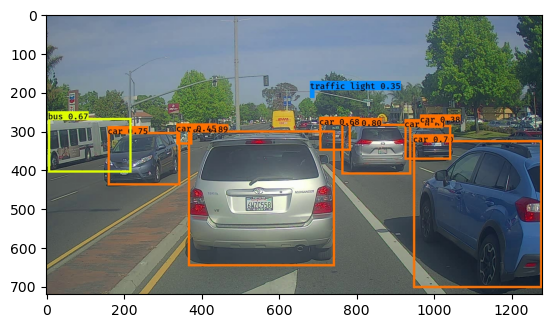

In [12]:
predict("test.jpg")

### 多个图像合并成视频的预测结果

In [13]:
list_images = [f"{i:04d}.jpg" for i in range(1, 121)]

import cv2

try:
    for filename in list_images:
        # Preprocess your image
        image, image_data = preprocess_image("images/" + filename, model_image_size = model_image_size)

        yolo_model_outputs = yolo_model(image_data)
        yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))

        out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

        # Draw bounding boxes on the image file
        out_img = draw_boxes(image, out_boxes, out_classes, class_names, out_scores)

        # 显示结果，每帧延迟 30ms（≈33fps 的感觉）
        cv2.imshow("YOLO Video from Sequence", out_img)

        if cv2.waitKey(30) & 0xFF == ord('q'):  # 按 q 退出
            break
        if cv2.getWindowProperty("YOLO Video from Sequence", cv2.WND_PROP_VISIBLE) < 1:  # 按窗口的关闭退出
            break
except Exception as e:
    print(e)
finally:
    cv2.destroyAllWindows()

最后，如果有兴趣更进一步使用YOLO的话，参考文献如下

- Joseph Redmon、Santosh Divvala、Ross Girshick、Ali Farhadi - [You Only Look Once：统一实时目标检测](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon、Ali Farhadi - [YOLO9000：更好、更快、更强](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K：又一个 Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- YOLO 官方网站 (https://pjreddie.com/darknet/yolo/)